# **Deep Q-Networks (DQN) Implementation for Lunarlander**
## Asim Awad Hussein Osman

## OverView:
the main changes I made to make it work were:
1. Change the batch size to 128
2. change the buffer size to 15000 to increase the number of available samples
3. Done scaling as I implemented it in Gymnasium on my local machine to allow for very fast experimentaion and trials, as the code runs very fast.
4. Made Epsilon Decay over 10,000 steps and increased exploration

## Setup

In [ ]:
# @title Import required packages (run me) { display-mode: "form" }
# Create the environment
import copy
from IPython.display import HTML
from base64 import b64encode
import chex
import gymnasium as gym
import collections # useful data structures
import jax
import random
import haiku as hk # jax neural network library
import numpy as np

import jax.numpy as jnp # jax numpy
import optax # jax optimizer library
import matplotlib.pyplot as plt # graph plotting library
import warnings
warnings.filterwarnings('ignore')
from helper import QActorState,select_greedy_action, update_target_params,TransitionMemory,build_network,q_learning_loss,select_epsilon_greedy_action
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from shutil import rmtree # deleting directories

In [ ]:
# Instantiate the memory
env_name = "LunarLander-v2"
env = gym.make(env_name)
# target_weights
# Reset the environment
s_0 = env.reset()[0]
print("Initial State::", s_0)

# Get environment obs space
obs_shape = env.observation_space.shape
print("Environment Obs Space Shape:", obs_shape)

# Get action space - e.g. discrete or continuous
print(f"Environment action space: {env.action_space}")

# Get num actions
num_actions = env.action_space.n
print(f"Number of actions: {num_actions}")

Initial State:: [ 0.00767441  1.4186584   0.7773246   0.34389496 -0.008886   -0.1760757
  0.          0.        ]
Environment Obs Space Shape: (8,)
Environment action space: Discrete(4)
Number of actions: 4


## **Q-Learning**

### **Greedy action selection**


In [ ]:
def select_greedy_action(q_values):

  # YOUR CODE
  action = jnp.argmax(q_values)
  # END YOUR CODE

  return action

### **Q-Network**


In [ ]:
def build_network(num_actions: int, layers=[20, 20]) -> hk.Transformed:
  """Factory for a simple MLP network for approximating Q-values."""

  def q_network(obs):
    network = hk.Sequential(
        [hk.Flatten(),
         hk.nets.MLP(layers + [num_actions])])
    return network(obs)

  return hk.without_apply_rng(hk.transform(q_network))

Let's initialise our Q-network and get the initial parameters.

In [ ]:
# Initialise Q-network
Q_NETWORK = build_network(num_actions=num_actions, layers=[20, 20]) # two actions
dummy_obs = jnp.zeros((1,*obs_shape), jnp.float32) # a dummy observation like the one in CartPole
random_key = jax.random.PRNGKey(0) # random key
Q_NETWORK_PARAMS = Q_NETWORK.init(random_key, dummy_obs) # Get initial params
print("Q-Learning params:", Q_NETWORK_PARAMS.keys())

Q-Learning params: dict_keys(['mlp/~/linear_0', 'mlp/~/linear_1', 'mlp/~/linear_2'])


### **The Bellman Equations**


In [ ]:

def compute_squared_error(pred, target):

  return  jnp.square(pred-target)


### **Target Q-network**


In [ ]:
# Store online and target parameters
QLearnParams = collections.namedtuple("Params", ["online", "target"])

# Q-learn-state
QLearnState = collections.namedtuple("LearnerState", ["count", "optim_state"])


We will be using **Optax** to optimize our neural network. We store the state of the optimizer in the `learn_state` above. Lets now instantiate the optimizer and add the initial Q-network parameters to a `QLearnParams` object.

In [ ]:
# Initialise Q-network optimizer
Q_LEARN_OPTIMIZER = optax.adam(1e-3) # learning rate
Q_LEARN_OPTIM_STATE = Q_LEARN_OPTIMIZER.init(Q_NETWORK_PARAMS) # initial optim state
# Create Learn State
Q_LEARNING_LEARN_STATE = QLearnState(0, Q_LEARN_OPTIM_STATE) # count set to zero initially
# Add initial Q-network weights to QLearnParams object
Q_LEARNING_PARAMS = QLearnParams(online=Q_NETWORK_PARAMS, target=Q_NETWORK_PARAMS) # target equal to online


In [ ]:
def update_target_params(learn_state, online_weights, target_weights, update_frequency=100):
  """A function to update target params every 100 training steps"""

  target = jax.lax.cond(
      jnp.mod(learn_state.count, update_frequency) == 0,
      lambda x, y: x,
      lambda x, y: y,
      online_weights,
      target_weights
  )

  params = QLearnParams(online_weights, target)

  return params

### **Q-learning loss**



In [ ]:
def batched_q_learning_loss(online_params, target_params, obs, actions, rewards, next_obs, dones):
    q_values = Q_NETWORK.apply(online_params, obs) # use the online parameters
    next_q_values = Q_NETWORK.apply(target_params, next_obs) # use the target parameters
    squared_error = jax.vmap(q_learning_loss)(q_values, actions, rewards, dones, next_q_values) # vmap q_learning_loss
    mean_squared_error = jnp.mean(squared_error) # mean squared error over batch
    return mean_squared_error

Now we can create the `q_learn` function which computes the gradient of the `batched_q_learning_loss` and then uses an Optax optimizer to update the network weights and then finally (maybe) updates the target parameters.

In [ ]:
def q_learn(rng, params, learner_state, memory):
  # Compute gradients
  grad_loss = jax.grad(batched_q_learning_loss)(params.online, params.target, memory.obs,
                                          memory.action, memory.reward,
                                          memory.next_obs, memory.done,
                                          ) # jax.grad

  # Get updates
  updates, opt_state = Q_LEARN_OPTIMIZER.update(grad_loss, learner_state.optim_state)

  # Apply them
  new_weights = optax.apply_updates(params.online, updates)

  # Maybe update target network
  params = update_target_params(learner_state, new_weights, params.target)

  # Increment learner step counter
  learner_state = QLearnState(learner_state.count + 1, opt_state)

  return params, learner_state

### **A General Purpose RL Training Loop**


In [ ]:
#@title Training loop (run me) { display-mode: "form" }

# NamedTuple to store transitions
Transition = collections.namedtuple("Transition", ["obs", "action", "reward", "next_obs", "done"])

def run_training_loop(env_name, agent_params, agent_select_action_func,

    agent_actor_state=None, agent_learn_func=None, agent_learner_state=None,
    agent_memory=None, num_episodes=1000, evaluator_period=10,
    evaluation_episodes=8, learn_steps_per_episode=1,
    train_every_timestep=False, video_subdir="",):


    # Setup Cartpole environment and recorder
    env = gym.make(env_name, render_mode="rgb_array") # training environment
    eval_env = gym.make(env_name, render_mode="rgb_array") # evaluation environment

    # Video dir
    video_dir = "./video"+"/"+video_subdir

    # Clear video dir
    try:
      rmtree(video_dir)
    except:
      pass

    # Wrap in recorder
    env = RecordVideo(env, video_dir+"/train", episode_trigger=lambda x: (x % evaluator_period) == 0,disable_logger=True)
    eval_env = RecordVideo(eval_env, video_dir+"/eval", episode_trigger=lambda x: (x % evaluation_episodes) == 0,disable_logger=True)

    # JAX random number generator
    rng = hk.PRNGSequence(jax.random.PRNGKey(0))
    # env.seed(0) # seed environment for reproducability
    random.seed(0)

    episode_returns = [] # List to store history of episode returns.
    evaluator_episode_returns = [] # List to store history of evaluator returns.
    timesteps = 0
    for episode in range(num_episodes):

        # Reset environment.
        obs = env.reset()[0]
        episode_return = 0
        done = False
        # print(f"Observation: {obs}, Shape: {np.shape(obs)}")

        while not done:

            # Agent select action.
            action, agent_actor_state = agent_select_action_func(
                                            next(rng),
                                            agent_params,
                                            agent_actor_state,
                                            np.array(obs)
                                        )

            # Step environment.
            next_obs, reward, terminated, truncated,_ = env.step(int(action))
            done =  terminated or truncated
            # Pack into transition.
            transition = Transition(obs, action, reward, next_obs, done)

            # Add transition to memory.
            if agent_memory: # check if agent has memory
              agent_memory.push(transition)

            # Add reward to episode return.
            episode_return += reward

            # Set obs to next obs before next environment step. CRITICAL!!!
            obs = next_obs

            # Increment timestep counter
            timesteps += 1

            # Maybe learn every timestep
            if train_every_timestep and (timesteps % 4 == 0) and agent_memory and agent_memory.is_ready(): # Make sure memory is ready
                # First sample memory and then pass the result to the learn function
                memory = agent_memory.sample()
                agent_params, agent_learner_state = agent_learn_func(
                                                        next(rng),
                                                        agent_params,
                                                        agent_learner_state,
                                                        memory
                                                    )

        episode_returns.append(episode_return)

        # At the end of every episode we do a learn step.
        if agent_memory and agent_memory.is_ready(): # Make sure memory is ready

            for _ in range(learn_steps_per_episode):
                # First sample memory and then pass the result to the learn function
                memory = agent_memory.sample()
                agent_params, agent_learner_state = agent_learn_func(
                                                        next(rng),
                                                        agent_params,
                                                        agent_learner_state,
                                                        memory
                                                    )

        if (episode % evaluator_period) == 0: # Do evaluation

            evaluator_episode_return = 0
            for eval_episode in range(evaluation_episodes):
                obs = eval_env.reset()[0]
                done = False
                while not done:
                    action, _ = agent_select_action_func(
                                    next(rng),
                                    agent_params,
                                    agent_actor_state,
                                    np.array(obs),
                                    evaluation=True
                                )

                    obs, reward,  terminated, truncated, _ = eval_env.step(int(action))
                    done =  terminated or truncated
                    evaluator_episode_return += reward

            evaluator_episode_return /= evaluation_episodes

            evaluator_episode_returns.append(evaluator_episode_return)

            logs = [
                    f"Episode: {episode}",
                    f"Epsilon: {get_epsilon(timesteps)}",
                    f"Episode Return: {episode_return}",
                    f"Average Episode Return: {np.mean(episode_returns[-20:])}",
                    f"Evaluator Episode Return: {evaluator_episode_return}"
            ]

            print(*logs, sep="\t") # Print the logs

    env.close()
    eval_env.close()

    return episode_returns, evaluator_episode_returns


### **Replay Buffer**


In [ ]:
class TransitionMemory(object):
  """A simple Python replay buffer."""

  def __init__(self, max_size=10_000, batch_size=256):
    self.batch_size = batch_size
    self.buffer = collections.deque(maxlen=max_size)

  def push(self, transition):

    # add transition to the replay buffer
    self.buffer.append(
        (transition.obs, transition.action, transition.reward,
          transition.next_obs, transition.done)
    )
  def is_ready(self):
    return self.batch_size <= len(self.buffer)

  def sample(self):
    # Randomly sample a batch of transitions from the buffer
    random_replay_sample = random.sample(self.buffer, self.batch_size)

    # Batch the transitions together
    obs_batch, action_batch, reward_batch, next_obs_batch, done_batch = zip(*random_replay_sample)

    return Transition(
        np.stack(obs_batch).astype("float32"),
        np.asarray(action_batch).astype("int32"),
        np.asarray(reward_batch).astype("float32"),
        np.stack(next_obs_batch).astype("float32"),
        np.asarray(done_batch).astype("float32")
    )
# Instantiate the memory
Q_LEARNING_MEMORY = TransitionMemory(max_size=15_000, batch_size=128)

### **Random exploration**


In [ ]:
def select_random_action(key, num_actions):
    # YOUR CODE
    action = jax.random.randint(
        key,
        shape=(),
        minval=0,
        maxval=num_actions
    )
    # END YOUR CODE

    return action

### **$\varepsilon$-greedy action selection**

In [ ]:
EPSILON_DECAY_TIMESTEPS = 10000 # decay epsilon over 3000 timesteps
EPSILON_MIN = 0.15 # 10% exploration

In [ ]:
def get_epsilon(num_timesteps):

  # YOUR CODE
  epsilon = 1.0 - num_timesteps / EPSILON_DECAY_TIMESTEPS

  epsilon = jax.lax.select(
      epsilon < EPSILON_MIN,
      EPSILON_MIN,
      epsilon
  )
  # END CODE

  return epsilon


In [ ]:
def select_epsilon_greedy_action(key, q_values, num_timesteps):
    num_actions = len(q_values) # number of available actions

    # YOUR CODE HERE
    epsilon = get_epsilon(num_timesteps) # get epsilon value

    should_explore = jax.random.uniform(key, minval=0.0, maxval=1.0) <= epsilon  # hint: a boolean expression to check if some random number is less than epsilon

    action = jax.lax.select(
        should_explore,
        select_random_action(key, num_actions) , # if should explore
        select_greedy_action(q_values) # if should be greedy
    )
    # END YOUR CODE

    return action



### **Q-learning select action**


In [ ]:
# Actor state stores the current number of timesteps
QActorState = collections.namedtuple("ActorState", ["count"])

def q_learning_select_action(key, params, actor_state, obs, evaluation=False):
    obs = jnp.expand_dims(obs, axis=0) # add dummy batch dim
    q_values = Q_NETWORK.apply(params.online, obs)[0] # remove batch dim

    action = select_epsilon_greedy_action(key, q_values, actor_state.count)
    greedy_action = select_greedy_action(q_values)

    action = jax.lax.select(
        evaluation,
        greedy_action,
        action
    )

    next_actor_state = QActorState(actor_state.count + 1) # increment timestep counter

    return action, next_actor_state

Q_LEARNING_ACTOR_STATE = QActorState(0) # counter set to zero

### **Training**
We can now put everything together using the agent-environment loop. We also `jit` the select action function and the learn function for some extra speed!

In [ ]:
# Jit functions
q_learning_select_action_jit = jax.jit(q_learning_select_action)
q_learn_jit = jax.jit(q_learn)

Starting training. This may take a few minutes to complete.
Episode: 0	Epsilon: 0.9911999702453613	Episode Return: -380.2207727231641	Average Episode Return: -380.2207727231641	Evaluator Episode Return: -641.2400995210653
Episode: 10	Epsilon: 0.8906000256538391	Episode Return: -159.05279369818902	Average Episode Return: -271.7338259906496	Evaluator Episode Return: -745.8984534666253
Episode: 20	Epsilon: 0.7878000140190125	Episode Return: -320.2003378562764	Average Episode Return: -227.9111434301163	Evaluator Episode Return: -853.9897708178642
Episode: 30	Epsilon: 0.6890000104904175	Episode Return: -201.45022887445242	Average Episode Return: -170.2429736860377	Evaluator Episode Return: -719.457024624039
Episode: 40	Epsilon: 0.5649999976158142	Episode Return: -50.86362746882925	Average Episode Return: -154.3750480353623	Evaluator Episode Return: -142.48056879806822
Episode: 50	Epsilon: 0.3698999881744385	Episode Return: -80.48673015010905	Average Episode Return: -168.79883021463615	Evalu

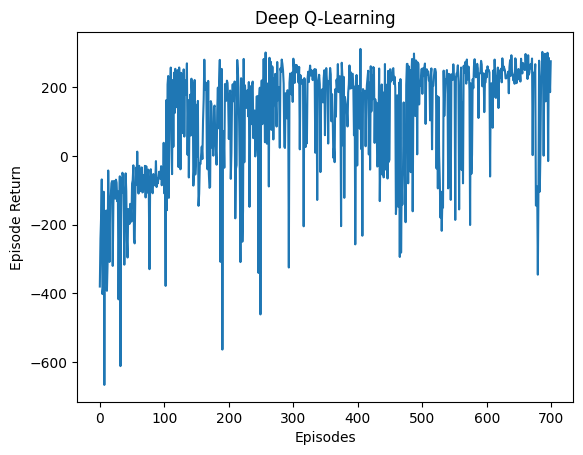

In [ ]:
# Run environment loop
print("Starting training. This may take a few minutes to complete.")
episode_returns, evaluator_returns = run_training_loop(
                                        env_name,
                                        Q_LEARNING_PARAMS,
                                        q_learning_select_action_jit,
                                        Q_LEARNING_ACTOR_STATE,
                                        q_learn_jit,
                                        Q_LEARNING_LEARN_STATE,
                                        Q_LEARNING_MEMORY,
                                        num_episodes=700,
                                        train_every_timestep=True, # do learning after every timestep
                                        video_subdir="q_learning"
                                    )

plt.plot(episode_returns)
plt.xlabel("Episodes")
plt.ylabel("Episode Return")
plt.title("Deep Q-Learning")
plt.show()

#### Comment
As you can see from the log, the increase of exploratino makes the agent learn very fast, but its drayback is the large variance, somthing common in such vanilla implementation for DQN. but overall the algorithm converges to the optimal policy.

In [2]:
import copy
from IPython.display import HTML
from base64 import b64encode

In [3]:
#@title Visualise Policy
#@markdown Choose an episode number that is a multiple of 100 and less than or equal to 1000, and **run this cell**.

episode_number = 900 #@param {type:"number"}

assert (episode_number % 100) == 0, "Episode number must be a multiple of 100 since we only record every 100th episode."
assert episode_number < 1001, "Episode number must be less than or equal to 1000"

eval_episode_number = int(episode_number / 100 * 32)
video_path = f"/content/Asim_RL_Assignment_1b.mp4"

mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)